In [ ]:
# In the code you provided, the prep network and hiding network are both part of the `Encoder` class, which is used to encode secret images into cover images. The reveal network is not explicitly mentioned in the code, but it is likely represented by the `Decoder` class, which is used to decode secret images from encoded cover images.

# The role of the prep network is to process the secret image and extract a feature map that represents its content. This feature map is then concatenated with the cover image and passed through the hiding network, which combines the two images to create an encoded cover image that contains the secret image.

# The reveal network, represented by the `Decoder` class in this code, takes as input an encoded cover image and processes it to extract and reconstruct the secret image. This allows the secret image to be recovered from the encoded cover image.

# In summary, the prep network processes the secret image to extract a feature map, the hiding network combines this feature map with the cover image to create an encoded cover image, and the reveal network extracts and reconstructs the secret image from the encoded cover image.

In [17]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms,utils,datasets
from torch.utils.data import Dataset,DataLoader
import os
import numpy as np
from tqdm import *
import time
import random

Start
 |
 v
Import libraries
 |
 v
Define model architecture (Encoder, Decoder, Make_model classes)
 |
 v
Load data (get_sub_data_loaders function)
 |
 v
Train model (train function)
 |--> Initialize loss functions (S_mseloss, C_mseloss)
 |--> Initialize optimizer and scheduler
 |--> Loop over epochs
      |--> Loop over batches of images from train loader
           |--> Split batch into cover and secret images
           |--> Pass cover and secret images through model (Make_model's forward method)
                |--> Encode secret image into cover image (Encoder's forward method)
                |--> Decode secret image from encoded cover image (Decoder's forward method)
           |--> Compute losses (S_mseloss, C_mseloss)
           |--> Backpropagate losses and update model parameters
 |
 v
Test model (display some images from test set)
 |--> Get batch of images from test loader
 |--> Split batch into cover and secret images
 |--> Pass cover and secret images through model (Make_model's forward method)
      |--> Encode secret image into cover image (Encoder's forward method)
      |--> Decode secret image from encoded cover image (Decoder's forward method)
 |--> Display cover, secret, encoded cover, and decoded secret images using matplotlib
 |
 v
End


In [18]:

cropH = 64
cropW = 64
dataDir = r'C:\Users\Yogi\Desktop\shree\deep-steg-master\data'
trainDir = os.path.join(dataDir,"train")
testDir = os.path.join(dataDir,"test")
batchSize = 64


This code defines a function get_sub_data_loaders() that returns data loaders for training and testing image datasets. The function first defines a variable sub_size which is the size of the subset of the data to be used. It then defines data transformations for both training and testing datasets, which include resizing the images, converting them to tensors, and normalizing them.

Next, the function creates an ImageFolder dataset for the training images using the specified data transformations. It then generates a random subset of indices of size sub_size and creates a new Subset dataset using these indices. A data loader is created for this subset of training images with the specified batch size, shuffle option, and number of workers.

The same process is repeated for the test images to create a test data loader. The function returns both the train and test data loaders, as well as the sizes of the train and test datasets.

In [19]:
def get_sub_data_loaders():
    sub_size = 3200

    data_transforms = {
        "train": transforms.Compose([
            transforms.Resize((cropH,cropW)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),

        "test": transforms.Compose([
            transforms.Resize((cropH, cropW)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    }

    train_images = datasets.ImageFolder(trainDir, data_transforms["train"])
    indices_train = list(range(len(train_images)))
    indices_train = random.sample(indices_train, len(train_images))
    sub_train_images = torch.utils.data.Subset(train_images, indices_train[:sub_size])
    train_loader = DataLoader(sub_train_images, batch_size=batchSize, shuffle=True, drop_last=True, num_workers=4)

    test_images = datasets.ImageFolder(testDir, data_transforms["test"])
    indices_test = list(range(len(test_images)))
    indices_test = random.sample(indices_test, len(indices_test))
    sub_test_images = torch.utils.data.Subset(test_images, indices_test[:sub_size])
    test_loader = DataLoader(sub_test_images, batch_size=batchSize, shuffle=False, drop_last=True, num_workers=4)

    train_set_size = len(sub_train_images)
    test_set_size = len(sub_test_images)

    return train_loader, test_loader, train_set_size, test_set_size


In [20]:

# def get_sub_data_loaders():
    
#     sub_size = 3200
    
#     data_transforms = {
#         "train":transforms.Compose([
#             transforms.RandomCrop((cropH,cropW),pad_if_needed=True),
#             transforms.ToTensor(),
#             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
#         ]),
        
#         "test":transforms.Compose([
#             transforms.CenterCrop((cropH,cropW)),
#             transforms.ToTensor(),
#             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
#         ])
#     }
#     train_images = datasets.ImageFolder(trainDir,data_transforms["train"])
#     indices_train = list(range(len(train_images)))
#     indices_train = random.sample(indices_train,len(train_images))
#     sub_train_imgages = torch.utils.data.Subset(train_images, indices_train[:sub_size])    
#     train_loader = DataLoader(sub_train_imgages,batch_size=batchSize,shuffle=True,drop_last =True,num_workers=4)
    
#     test_images = datasets.ImageFolder(testDir,data_transforms["test"])
#     indices_test = list(range(len(test_images)))
#     indices_test = random.sample(indices_test,len(indices_test))
#     sub_test_imgages = torch.utils.data.Subset(train_images, indices_test[:sub_size])  
#     test_loader = DataLoader(sub_test_imgages,batch_size=batchSize,shuffle=False,drop_last =True,num_workers=4)
    
#     train_set_size = len(sub_train_imgages)
#     test_set_size = len(sub_test_imgages)
#     #print("type of train_images ",type(train_images))
#     #print("type of train_loader ",type(train_loader))
    
#     return train_loader,test_loader,train_set_size,test_set_size


train_images len =  1864
test_images len  =  1838
labels  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
images size =  torch.Size([64, 3, 128, 128])


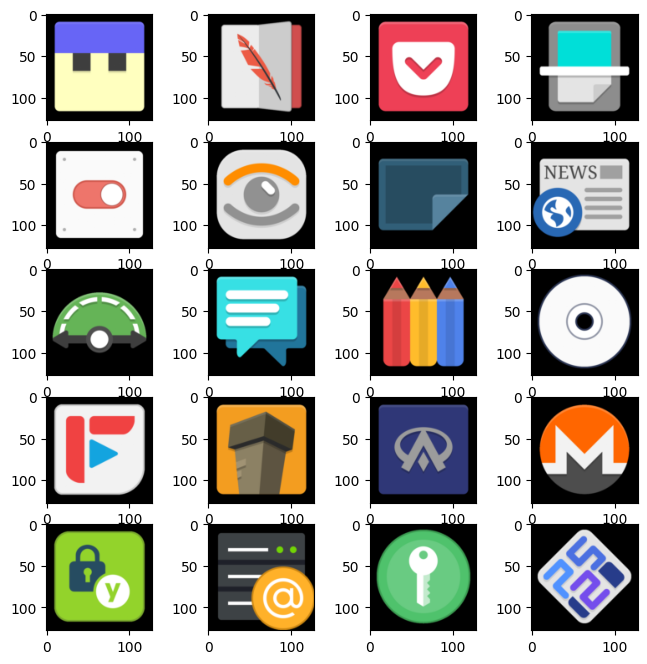

In [21]:

fig = plt.figure(figsize=(8,8)) 
colums = 4
rows = 5


train_loader,test_loader,train_set_size,test_set_size = get_sub_data_loaders()

print("train_images len = ",train_set_size)
print("test_images len  = ",test_set_size)
    

dataiter = iter(train_loader)
images,labels =next(dataiter)
#print("images ",images)
print("labels ",labels)
print("images size = ",images.size())

for i in range(1,colums*rows+1):
    fig.add_subplot(rows,colums,i)
    
    img = images[i]/2 +0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0))) 
plt.show()

an autoencoder model that includes a prep network, a hiding network, and a reveal network. The prep network converts the input image into a feature map and, if its size is smaller than another input image, it enlarges the feature map to the same size. Both the hiding and reveal networks use 50 convolutional kernels with kernel sizes of 3, 4, and 5. It's important to note that the activation function for the image output layer is tanh, not ReLU.

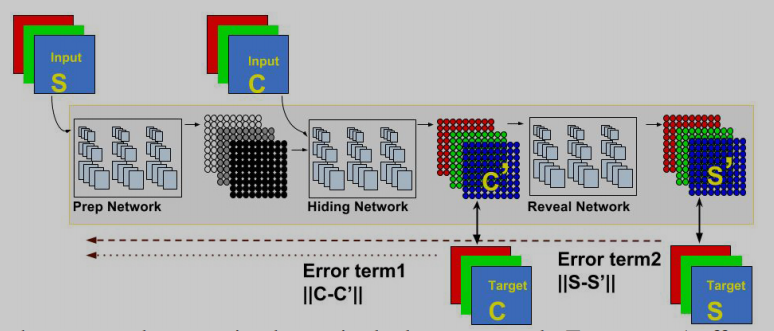

This code defines an Encoder class that inherits from PyTorch’s nn.Module class. The Encoder class represents a neural network model that includes a prep network and a hiding network for encoding secret images into cover images.

In the __init__ method, the class defines several convolutional layers with different kernel sizes and numbers of output channels. These layers are used in the prep and hiding networks to process the input images.

The forward method takes as input a secret image input_S and a cover image input_C. It applies several convolutional layers with ReLU activations to the secret image, concatenating the outputs of different layers to create a thicker feature map. This feature map is then concatenated with the cover image and passed through several more convolutional layers with ReLU activations. The final output is generated by applying a convolutional layer with a tanh activation to produce an RGB image.

The method returns the output image, which is the encoded cover image containing the secret image.

In [22]:

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        # prep Network
        self.conv1 = nn.Conv2d(3,50,3,padding = 1)
        self.conv2 = nn.Conv2d(3,10,4,padding = 1)
        self.conv3 = nn.Conv2d(3,5,5,padding = 2)
        
        self.conv4 = nn.Conv2d(65,50,3,padding = 1)
        self.conv5 = nn.Conv2d(65,10,4,padding = 1)
        self.conv6 = nn.Conv2d(65,5,5,padding = 2)
        
        #Hiding Network 
        self.conv7 = nn.Conv2d(68,50,3,padding = 1)
        self.conv8 = nn.Conv2d(68,10,4,padding = 1)
        self.conv9 = nn.Conv2d(68,5,5,padding = 2)
        
        self.conv10 = nn.Conv2d(65,50,3,padding = 1)
        self.conv11 = nn.Conv2d(65,10,4,padding = 1)
        self.conv12 = nn.Conv2d(65,5,5,padding = 2)
        
        self.conv13 = nn.Conv2d(65,50,3,padding = 1)
        self.conv14 = nn.Conv2d(65,10,4,padding = 1)
        self.conv15 = nn.Conv2d(65,5,5,padding = 2)
        
        self.conv16 = nn.Conv2d(65,50,3,padding = 1)
        self.conv17 = nn.Conv2d(65,10,4,padding = 1)
        self.conv18 = nn.Conv2d(65,5,5,padding = 2)
        
        self.conv19 = nn.Conv2d(65,50,3,padding = 1)
        self.conv20 = nn.Conv2d(65,10,4,padding = 1)
        self.conv21 = nn.Conv2d(65,5,5,padding = 2)
        
        self.conv22 = nn.Conv2d(65,3,3,padding = 1)
        
    def forward(self,input_S,input_C):
        x1 = F.relu(self.conv1(input_S))
        x2 = F.relu(self.conv2(input_S))
        # This comment explains the effect of applying a convolution with a kernel size of 4 and padding of 1 on the height and width of an image. After the convolution, the height and width of the image are reduced by 3 units. 
        # Adding a border of 1 pixel around the image increases the height and width by 2 units, but they are still 1 unit smaller than the original image. 
        # The (0,1,0,1) indicates that two borders are added to the right and bottom sides of the image.
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv3(input_S))
        x4 = torch.cat((x1,x2,x3),1) 
        
        x1 = F.relu(self.conv4(x4))
        x2 = F.relu(self.conv5(x4))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv6(x4))
        x4 = torch.cat((x1,x2,x3),1) 
        
        x4 = torch.cat((input_C,x4),1) 
        
            #hiding network
        x1 = F.relu(self.conv7(x4))
        x2 = F.relu(self.conv8(x4))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv9(x4))
        x4 = torch.cat((x1,x2,x3),1) 
        
        x1 = F.relu(self.conv10(x4))
        x2 = F.relu(self.conv11(x4))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv12(x4))
        x4 = torch.cat((x1,x2,x3),1) 
        
        x1 = F.relu(self.conv13(x4))
        x2 = F.relu(self.conv14(x4))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv15(x4))
        x4 = torch.cat((x1,x2,x3),1)  
        
        x1 = F.relu(self.conv16(x4))
        x2 = F.relu(self.conv17(x4))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv18(x4))
        x4 = torch.cat((x1,x2,x3),1) 
        
        x1 = F.relu(self.conv19(x4))
        x2 = F.relu(self.conv20(x4))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv21(x4))
        x4 = torch.cat((x1,x2,x3),1) 
        
        output = torch.tanh(self.conv22(x4))
        
        return output
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()

        # Decoder Reconstruct the secret image
        self.conv1 = nn.Conv2d(3,50,3,padding = 1)
        self.conv2 = nn.Conv2d(3,10,4,padding = 1)
        self.conv3 = nn.Conv2d(3,5,5,padding = 2)

        self.conv4 = nn.Conv2d(65,50,3,padding = 1)
        self.conv5 = nn.Conv2d(65,10,4,padding = 1)
        self.conv6 = nn.Conv2d(65,5,5,padding = 2)

        self.conv7 = nn.Conv2d(65,50,3,padding = 1)
        self.conv8 = nn.Conv2d(65,10,4,padding = 1)
        self.conv9 = nn.Conv2d(65,5,5,padding = 2)
        
        self.conv10 = nn.Conv2d(65,50,3,padding = 1)
        self.conv11 = nn.Conv2d(65,10,4,padding = 1)
        self.conv12 = nn.Conv2d(65,5,5,padding = 2)
        
        self.conv13 = nn.Conv2d(65,50,3,padding = 1)
        self.conv14 = nn.Conv2d(65,10,4,padding = 1)
        self.conv15 = nn.Conv2d(65,5,5,padding = 2)
        
        self.conv16 = nn.Conv2d(65,3,3,padding = 1)
    
    def forward(self,x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv3(x))
        x4 = torch.cat((x1,x2,x3),1) 
        
        x1 = F.relu(self.conv4(x4))
        x2 = F.relu(self.conv5(x4))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv6(x4))
        x4 = torch.cat((x1,x2,x3),1) 
        
        x1 = F.relu(self.conv7(x4))
        x2 = F.relu(self.conv8(x4))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv9(x4))
        x4 = torch.cat((x1,x2,x3),1) 
        
        x1 = F.relu(self.conv10(x4))
        x2 = F.relu(self.conv11(x4))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv12(x4))
        x4 = torch.cat((x1,x2,x3),1) 
        
        x1 = F.relu(self.conv13(x4))
        x2 = F.relu(self.conv14(x4))
        x2 = F.pad(x2,(0,1,0,1),'constant',value=0) 
        x3 = F.relu(self.conv15(x4))
        x4 = torch.cat((x1,x2,x3),1) 
        
        output = torch.tanh(self.conv16(x4))
        
        return output

class Make_model(nn.Module):
    def __init__(self):
        super(Make_model,self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self,input_S,input_C):
        output_Cprime = self.encoder(input_S,input_C)
        output_Sprime = self.decoder(output_Cprime)
        
        return output_Cprime,output_Sprime
    
    

`output_Cprime` and `output_Sprime` are the outputs of the `Make_model` class's `forward` method. `output_Cprime` is the encoded cover image produced by passing the secret image and the cover image through the encoder network. `output_Sprime` is the decoded secret image produced by passing the encoded cover image through the decoder network.

In other words, `output_Cprime` is an image that looks similar to the input cover image but contains information about the secret image. `output_Sprime` is an image that is reconstructed from the encoded cover image and should look similar to the input secret image.

`output_C` and `output_S` are the outputs of the `Make_model` class's `forward` method. `output_C` is the encoded cover image produced by passing the secret image and the cover image through the encoder network. `output_S` is the decoded secret image produced by passing the encoded cover image through the decoder network.

`S_mseloss` and `C_mseloss` are two loss functions defined in the `train` function. Both are mean squared error (MSE) losses, which measure the average squared difference between two tensors. `S_mseloss` is used to compute the reconstruction error between the input secret image and the decoded secret image, while `C_mseloss` is used to compute the reconstruction error between the input cover image and the encoded cover image.

In other words, `S_mseloss` measures how well the model can reconstruct the secret image from the encoded cover image, while `C_mseloss` measures how well the model can encode the secret image into the cover image without changing its appearance too much.

In [23]:
AEmodel =Make_model()
loss_history = []

In [24]:
import torch
import torch.cuda as cuda


This code defines a train() function that trains an autoencoder model on a dataset of images. The function first sets the device to use for training (either CPU or GPU) and moves the model to the device. It then loads the training and test data using the get_sub_data_loaders() function.

The function defines two mean squared error loss functions for calculating the reconstruction loss of the secret and cover images, respectively. It also defines an optimizer and a learning rate scheduler for updating the model’s parameters during training.

The function then enters a loop to train the model for 30 epochs. For each epoch, it iterates over the training data, sending the images to the device and setting the model to training mode. The optimizer’s gradients are zeroed, and the input images are split into secret and cover images. The model is used to generate output images, and the loss is calculated as a weighted sum of the secret and cover image reconstruction losses. The loss is backpropagated, and the optimizer updates the model’s parameters.

At the end of each epoch, the average loss is printed. The function does not return any values.

In [25]:


def train():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    #torch.cuda.set_device(1) #选择第二块显卡
    print("device : ",device)
    
    AEmodel.to(device)
    
    train_loader,test_loader,train_set_size,test_set_size = get_sub_data_loaders()
    
    
   
    S_mseloss = torch.nn.MSELoss().to(device) 
    C_mseloss = torch.nn.MSELoss().to(device) 
    
    optimizer = torch.optim.Adam(AEmodel.parameters())
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9)
    loss_func = nn.CrossEntropyLoss().cuda()  # the target label is not one-hotted
    
    
    for epoch in range(30):
        
        loss_all,c_loss,s_loss = [],[],[]
        t = tqdm(train_loader) 
        
        for images, _ in t: 
            images = images.to(device)
            AEmodel.train() 
            
            with torch.enable_grad():
                optimizer.zero_grad() 
                The active selection is a comment in Python, written in Chinese. The comment translates to "Images are a batch of images, divided into two parts: the visible image and the secret image". 

In the context of image processing and deep learning, a batch refers to the number of images that the model processes at one time. The comment suggests that each batch of images contains two types of images: visible images and secret images.

The term "visible image" likely refers to the images that are visible to the user, while the term "secret image" likely refers to the images that are hidden within the visible images, possibly using a technique like steganography.

Remember, comments in Python start with the hash symbol (`#`) and are used to explain what the following or preceding code is doing. They are not executed by the Python interpreter, and are there solely for the benefit of the developer and any others who may read the code.
                # images 为一个batch的图像，分为明图和密图两部分
                input_C = images[0:images.shape[0] // 2]
                input_S = images[images.shape[0] // 2:]
            
                output_C,output_S = AEmodel(input_S,input_C)
                 
                #计算损失
                beta = 1.0
                ssLoss = S_mseloss(input_S,output_S)
                ccLoss = C_mseloss(input_C,output_C)
                loss =  beta * ssLoss + ccLoss
            
                loss.backward()
                optimizer.step()
            
                losses = {
                    "loss_all":loss.item(),
                    "ssLoss":ssLoss.item(),
                    "ccLoss":ccLoss.item()
                }
                loss_all.append(losses["loss_all"])
                c_loss.append(losses["ccLoss"])
                s_loss.append(losses["ssLoss"])
                
        loss_history.append(loss_all)
        print("[epoch = ",epoch+1,"] loss: ",np.mean(loss_all),"s_loss = ",np.mean(c_loss),"c_loss = ",np.mean(s_loss))
        
    

In [26]:
#%%capture output
train()

device :  cpu


100%|██████████| 29/29 [15:51<00:00, 32.80s/it]


[epoch =  1 ] loss:  0.6857656949552996 s_loss =  0.29014691710472107 c_loss =  0.39561878709957515


100%|██████████| 29/29 [17:11<00:00, 35.57s/it]


[epoch =  2 ] loss:  0.37632276477484866 s_loss =  0.10163663391923082 c_loss =  0.27468613149790927


100%|██████████| 29/29 [37:24<00:00, 77.41s/it] 


[epoch =  3 ] loss:  0.3152795423721445 s_loss =  0.06655782396937239 c_loss =  0.2487217177604807


100%|██████████| 29/29 [13:53<00:00, 28.75s/it]


[epoch =  4 ] loss:  0.32686451694061014 s_loss =  0.08773008233000493 c_loss =  0.2391344360236464


100%|██████████| 29/29 [14:23<00:00, 29.77s/it]


[epoch =  5 ] loss:  0.25434993618521196 s_loss =  0.055321033016361036 c_loss =  0.19902890304039264


100%|██████████| 29/29 [13:17<00:00, 27.51s/it]


[epoch =  6 ] loss:  0.1825474993935947 s_loss =  0.04817286705405548 c_loss =  0.13437463214685177


100%|██████████| 29/29 [13:44<00:00, 28.42s/it]


[epoch =  7 ] loss:  0.16244621883178578 s_loss =  0.039068735429439054 c_loss =  0.12337748269582617


100%|██████████| 29/29 [14:58<00:00, 30.99s/it]


[epoch =  8 ] loss:  0.14549525030728044 s_loss =  0.03254738218825439 c_loss =  0.11294786837594263


100%|██████████| 29/29 [15:20<00:00, 31.73s/it]


[epoch =  9 ] loss:  0.13499890653223828 s_loss =  0.030095126415634978 c_loss =  0.10490378069466558


100%|██████████| 29/29 [13:47<00:00, 28.53s/it]


[epoch =  10 ] loss:  0.14019519553102297 s_loss =  0.036743398113497375 c_loss =  0.1034517963898593


100%|██████████| 29/29 [14:36<00:00, 30.24s/it]


[epoch =  11 ] loss:  0.133494489151856 s_loss =  0.043658499766526554 c_loss =  0.08983598957801688


100%|██████████| 29/29 [16:13<00:00, 33.57s/it]


[epoch =  12 ] loss:  0.11730728169967389 s_loss =  0.03812722534198185 c_loss =  0.07918005526579659


100%|██████████| 29/29 [15:25<00:00, 31.91s/it]


[epoch =  13 ] loss:  0.10604104810747607 s_loss =  0.03551142881142682 c_loss =  0.07052961968142411


100%|██████████| 29/29 [14:27<00:00, 29.92s/it]


[epoch =  14 ] loss:  0.10990889139216521 s_loss =  0.03716413638201253 c_loss =  0.07274475359711154


100%|██████████| 29/29 [14:19<00:00, 29.62s/it]


[epoch =  15 ] loss:  0.09666404564832819 s_loss =  0.03608267497399758 c_loss =  0.060581370674330615


100%|██████████| 29/29 [14:31<00:00, 30.04s/it]


[epoch =  16 ] loss:  0.09087901947827175 s_loss =  0.03072120840179509 c_loss =  0.060157811461851514


100%|██████████| 29/29 [14:24<00:00, 29.82s/it]


[epoch =  17 ] loss:  0.12124436477134967 s_loss =  0.04324286097082598 c_loss =  0.0780015036720654


100%|██████████| 29/29 [14:14<00:00, 29.46s/it]


[epoch =  18 ] loss:  0.093139943377725 s_loss =  0.03439791975864049 c_loss =  0.05874202323370967


100%|██████████| 29/29 [13:45<00:00, 28.47s/it]


[epoch =  19 ] loss:  0.0964426516458906 s_loss =  0.03517957564828725 c_loss =  0.06126307580491592


100%|██████████| 29/29 [14:25<00:00, 29.84s/it]


[epoch =  20 ] loss:  0.09278690660821981 s_loss =  0.03554578208974723 c_loss =  0.05724112445424343


100%|██████████| 29/29 [14:22<00:00, 29.74s/it]


[epoch =  21 ] loss:  0.07898782424885652 s_loss =  0.030861003902451747 c_loss =  0.048126819832571624


100%|██████████| 29/29 [14:08<00:00, 29.25s/it]


[epoch =  22 ] loss:  0.07942547957445013 s_loss =  0.02926359592198298 c_loss =  0.050161884005727436


100%|██████████| 29/29 [13:25<00:00, 27.79s/it]


[epoch =  23 ] loss:  0.07499899663801851 s_loss =  0.02872567655968255 c_loss =  0.04627332039948168


100%|██████████| 29/29 [13:44<00:00, 28.43s/it]


[epoch =  24 ] loss:  0.07241237715914331 s_loss =  0.028068453651563876 c_loss =  0.04434392370026687


100%|██████████| 29/29 [14:32<00:00, 30.08s/it]


[epoch =  25 ] loss:  0.07191853751910143 s_loss =  0.027259703340201544 c_loss =  0.044658834178899896


100%|██████████| 29/29 [14:55<00:00, 30.86s/it]


[epoch =  26 ] loss:  0.06834284999761088 s_loss =  0.02704029048568216 c_loss =  0.041302560411136724


100%|██████████| 29/29 [14:24<00:00, 29.82s/it]


[epoch =  27 ] loss:  0.06698946128117628 s_loss =  0.026881416103449362 c_loss =  0.04010804517772691


100%|██████████| 29/29 [14:40<00:00, 30.35s/it]


[epoch =  28 ] loss:  0.07062575310982507 s_loss =  0.0275619320314506 c_loss =  0.043063821206832754


100%|██████████| 29/29 [14:23<00:00, 29.77s/it]


[epoch =  29 ] loss:  0.08211390006131139 s_loss =  0.03346219954305682 c_loss =  0.04865169987596314


100%|██████████| 29/29 [14:06<00:00, 29.19s/it]

[epoch =  30 ] loss:  0.07446555112456453 s_loss =  0.030219968922179322 c_loss =  0.04424558245930178


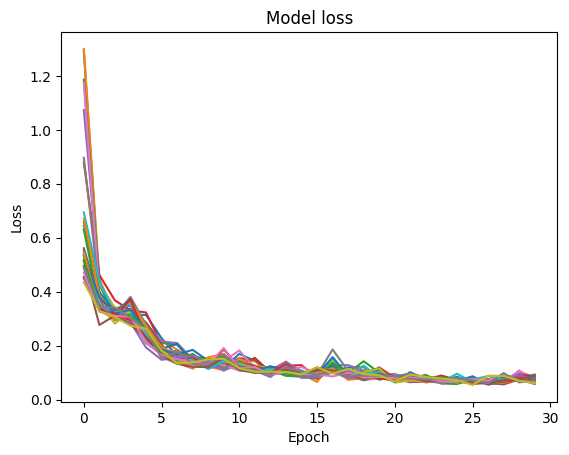

In [27]:
# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


In [28]:
torch.tensor(loss_history).size()

torch.Size([30, 29])

In [29]:
# save model
path = "./modelgpu_3200.pth"
torch.save(AEmodel.state_dict(), path)


In [30]:
# load model
AEmodel = Make_model()
AEmodel.load_state_dict(torch.load(path))
AEmodel.eval()


Make_model(
  (encoder): Encoder(
    (conv1): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(3, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv4): Conv2d(65, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(65, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (conv6): Conv2d(65, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv7): Conv2d(68, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv8): Conv2d(68, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (conv9): Conv2d(68, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv10): Conv2d(65, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv11): Conv2d(65, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (conv12): Conv2d(65, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv13): Conv2d(6

labels  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
images size =  torch.Size([64, 3, 64, 64])
images c size =  torch.Size([5, 3, 64, 64])
images s size =  torch.Size([5, 3, 64, 64])


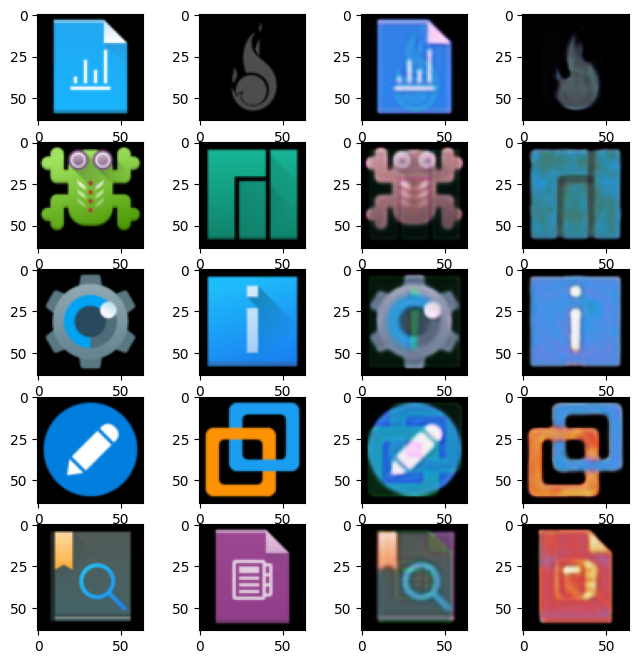

In [32]:

fig = plt.figure(figsize=(8,8)) 
colums = 4
rows = 5


dataiter = iter(test_loader)
images,labels = next(dataiter)
#print("images ",images)
print("labels ",labels)
print("images size = ",images.size())



input_C = images[0:5]
input_S = images[5:10]
print("images c size = ",input_C.size())
print("images s size = ",input_S.size())

for i in range(0,rows):
    fig.add_subplot(rows,colums,i*colums+1)
    
    img = input_C[i]/2 +0.5 #unnormalize
    npimg = img.numpy()
    #print('npimg:',npimg)
    plt.imshow(np.transpose(npimg,(1,2,0))) 
    
    fig.add_subplot(rows,colums,i*colums+1+1)
    s_img = input_S[i]/2 +0.5
    npimg_s = s_img.numpy()
    #print('npimg_s:',npimg_s)
    plt.imshow(np.transpose(npimg_s,(1,2,0))) 
    
    c_img_encode,s_img_decode = AEmodel(input_S[i].unsqueeze(0),input_C[i].unsqueeze(0)) # 获取编码图和密图
    
    fig.add_subplot(rows,colums,i*colums+2+1)
    c_img_encode = c_img_encode/2 +0.5
    npc_img_encode = c_img_encode.detach().squeeze().numpy()
    #print('npc_img_encode:',npc_img_encode)
    plt.imshow(np.transpose(npc_img_encode,(1,2,0))) 
    
    fig.add_subplot(rows,colums,i*colums+3+1)
    s_img_decode = s_img_decode/2 +0.5
    nps_img_decode = s_img_decode.detach().squeeze().numpy()
    #print('nps_img_decode:',nps_img_decode)
    plt.imshow(np.transpose(nps_img_decode,(1,2,0))) 
    
plt.show()